# General information

Here, the preceding elements represent the following:

- x0, y0: The coordinates of the top left of the bounding box
- x1, y1: The coordinates of the bottom right of the bounding box
- w, h: The width and height of the bounding box
- xc, yc: The coordinates of the centroid of the bounding box

As an example, let's look at the following screenshot in which xc, yc = 1099, 1035; w, h = 500,
500; x0, y0 = 849, 785; and x1, y1 = 1349, 1285:

Therefore, the goal of single-object detection will be to predict a bounding box using four
numbers. In the case of square objects, we can fix the width and height and simplify the
problem to predict just two numbers. In this chapter, we will learn to create an algorithm to
locate the fovea in eye images using two numbers.

The ADAM challenge focuses on the investigation and development of algorithms associated with the diagnosis of Age-related Macular degeneration (AMD) and segmentation of lesions in fundus photos from AMD patients. The goal of the challenge is to evaluate and compare automated algorithms for the detection of AMD on a common dataset of retinal fundus images. We invite the medical image analysis community to participate by developing and testing existing and novel automated fundus classification and segmentation methods

# Data Exploratory

In [3]:
%%time
import shutil
import zipfile
path_to_zip_file='/content/drive/My Drive/Data/Vision/AMD challenge/AMD-Training400.zip'
directory_to_extract_to='/content/data/'
z = zipfile.ZipFile(path_to_zip_file, allowZip64=True)
for member in z.infolist():
  try:
    z.extract(member,path=directory_to_extract_to)
  except:
    continue
    # log the error, the member.filename, whatever
# PLEASE NOTE: MOVE FOVEA_LOCATION.XLSX FROM DRIVE_VISION_AMDCHALLENGE TO DATA_TRAINING400 GOOGLE COLAB as below:
shutil.move("/content/drive/My Drive/Data/Vision/AMD challenge/Fovea_location.xlsx", "/content/data/Training400")

CPU times: user 4.84 s, sys: 1.46 s, total: 6.3 s
Wall time: 11.8 s


1. Let's begin by loading Fovea_location.xlsx and printing out its head:

Then, we loaded the file into a pandas DataFrame and printed out its head. The
DataFrame has three columns: imgName, Fovea_X, and Fovea_Y. The imgName column
refers to the image filename, while Fovea_X and Fovea_Y represent the X and Y
coordinates of the fovea center. Note that the first 89 rows correspond to the AMD images
and start with the letter A.

In [4]:
import os
import pandas as pd

path2data="./data/"

# full path of labels file
path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")

# maske sure to install xlrd
labels_df=pd.read_excel(path2labels,index_col="ID")

labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [5]:
path2labels

'./data/Training400/Fovea_location.xlsx'

In step 2, we printed out the tail of the DataFrame. You can see that ID reaches 400, the
same as the number of images. Also, note that the last 311 rows correspond to the Non-AMD
images and start with the letter N.

In [6]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


In step 3, we showed the scatterplot of Fovea_X and Fovea_Y. We used the seaborn library
to show the scatterplot. Seaborn is a Python data visualization library based on
matplotlib. It provides a high-level interface for drawing attractive and informative
statistical graphics.

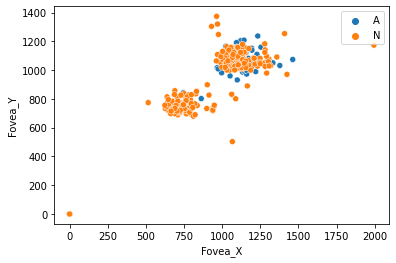

In [7]:
# make sure seaborn is installed!
import seaborn as sns
%matplotlib inline

AorN=[imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y=labels_df['Fovea_Y'],hue=AorN)

4. Next, we will show a few sample images. We will import the required packages
and fix the random seed:

In step 4, we displayed a few random images with the fovea bounding boxes. The fovea
location is given as a center point. Therefore, to show a bounding box, we create a rectangle
using rectangle from the PIL.imageDraw package at the center of the fovea. We also
printed the image sizes. As we saw, images have different sizes.

In [8]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)

In [9]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows,ncols=2,3

<Figure size 1080x648 with 0 Axes>

Then, we will select a random set of image id

In [10]:
# get imgName column
imgName=labels_df["imgName"]

# get ids
ids=labels_df.index

# select random ids
rndIds=np.random.choice(ids,nrows*ncols)
print(rndIds)

[ 73 371 160 294 217 191]


Next, we will define a helper function to load an image and its label from the local
files:

In [11]:
# Dua vao ten du lieu trong labels_df tim image trong data trung voi ten do
def load_img_label(labels_df,id_):    
    imgName=labels_df["imgName"]    
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
            
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    
    # centroid
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    
    label=(x,y)
    return img,label

Next, we will define a helper function to show the image and label as a bounding
box:

In [12]:
def show_img_label(img,label,w_h=(50,50),thickness=2):   
    w,h=w_h                   
    cx,cy=label
    
    # draw a rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=thickness)

    plt.imshow(np.asarray(img))

Then, we will show the selected images together with the fovea bounding boxes:

(2124, 2056) (1037.89889229694, 1115.71768088143)
(1444, 1444) (635.148992978281, 744.648850248249)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1122.08407442503, 1067.58829793991)
(2124, 2056) (1092.93333646222, 1055.15333296773)
(2124, 2056) (1112.50135915347, 1070.7251775623)


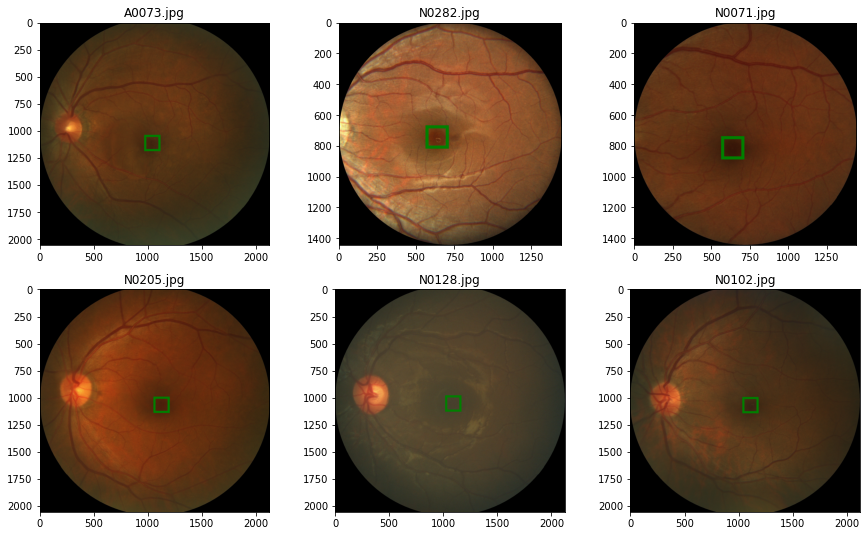

In [13]:
for i,id_ in enumerate(rndIds):
    
    img,label=load_img_label(labels_df,id_)   
    print(img.size,label)
    
    plt.subplot(nrows, ncols, i+1) 
    show_img_label(img,label,w_h=(150,150),thickness=20)
    plt.title(imgName[id_])

Luu y: chi co du lieu center diem vang, o vuong xanh la do tu ve

5. Next, we will collect the image widths and heights in two lists:

In [18]:
imgName

ID
1      A0001.jpg
2      A0002.jpg
3      A0003.jpg
4      A0004.jpg
5      A0005.jpg
         ...    
396    N0307.jpg
397    N0308.jpg
398    N0309.jpg
399    N0310.jpg
400    N0311.jpg
Name: imgName, Length: 400, dtype: object

In [15]:
h_list,w_list=[],[]
for id_ in ids:
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
        
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
        
    # load image
    try:
      img = Image.open(fullPath2img)
    except:
      continue
    h,w=img.size
    h_list.append(h)
    w_list.append(w)

6. Then, we will plot the distributions of heights and widths:

In [22]:
print(h_list[:20])

[2124, 2124, 2124, 2124, 2124, 2124, 2124, 1444, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 1444, 2124]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


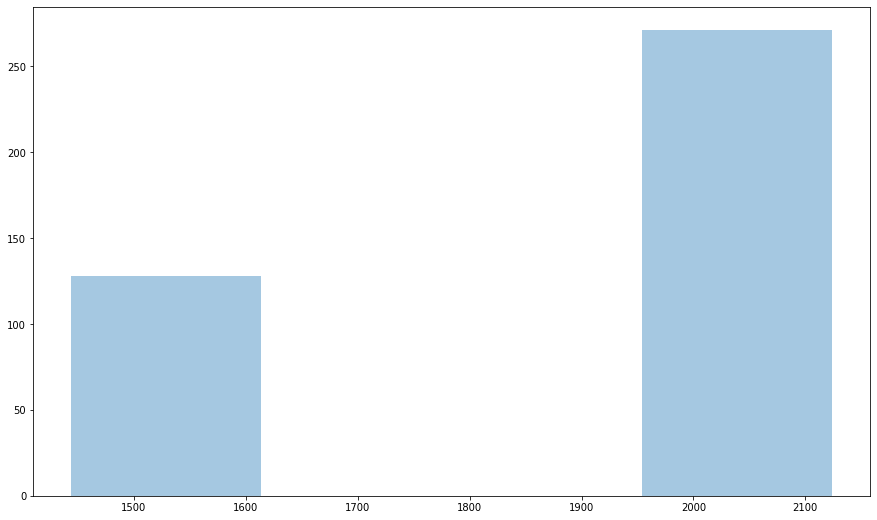

In [16]:
sns.distplot(a=h_list, kde=False)

In [23]:
print(w_list[:20])

[2056, 2056, 2056, 2056, 2056, 2056, 2056, 1444, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 1444, 2056]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


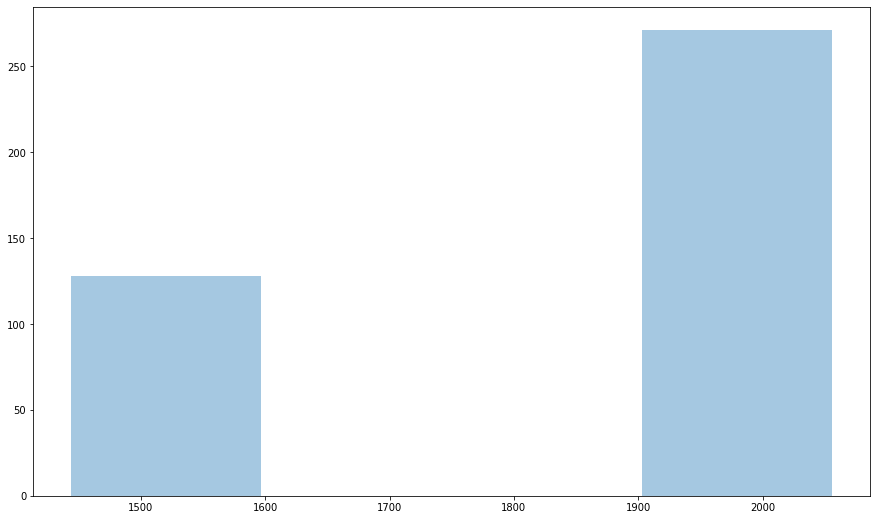

In [17]:
sns.distplot(a=w_list, kde=False)

In step 5, we get lists of image heights and widths. This will be used to plot the distributions
of heights and widths in step 6. The plots of distributions reveal that the majority of heights
and width are in the range of 1900 to 2100.

# Data Transformation for Object Detection

In [ ]:
import torchvision.transforms.functional as TF

def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    cx, cy= label
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


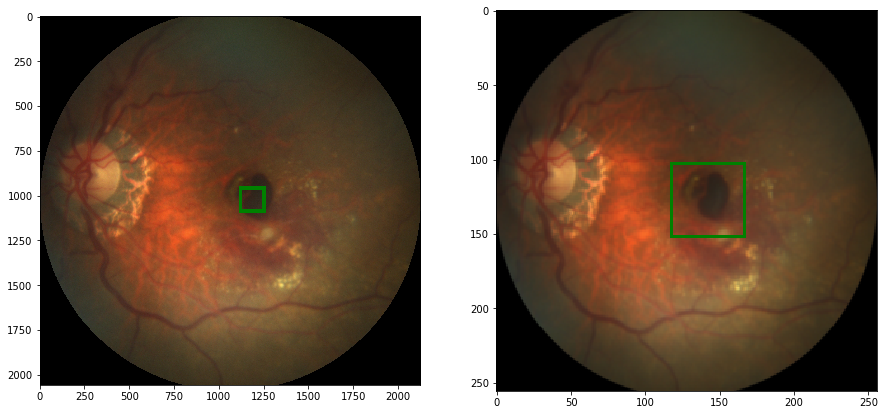

In [ ]:
# load image
img, label=load_img_label(labels_df,1)   
print(img.size,label)

img_r,label_r=resize_img_label(img,label)
print(img_r.size,label_r)

plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(img_r,label_r)

In [ ]:
def random_hflip(image,label):
    w,h=image.size
    x,y=label        

    image = TF.hflip(image)
    label = w-x, y
    return image,label

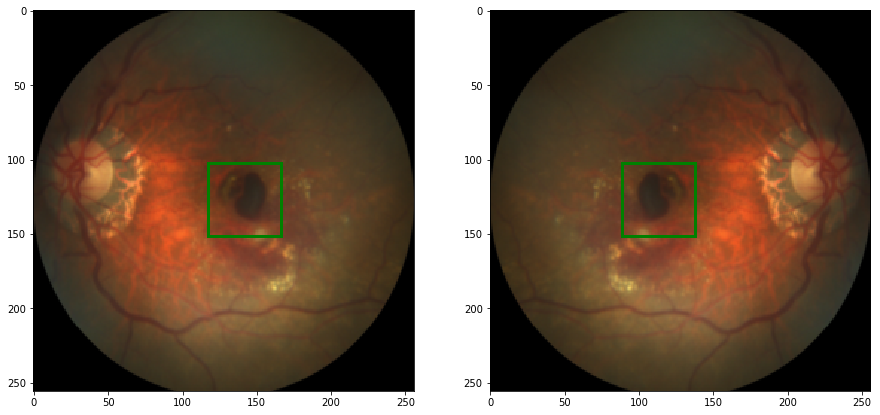

In [ ]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_fh,label_fh=random_hflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fh,label_fh)

In [ ]:

def random_vflip(image,label):
    w,h=image.size
    x,y=label

    image = TF.vflip(image)
    label = x, w-y
    return image, label

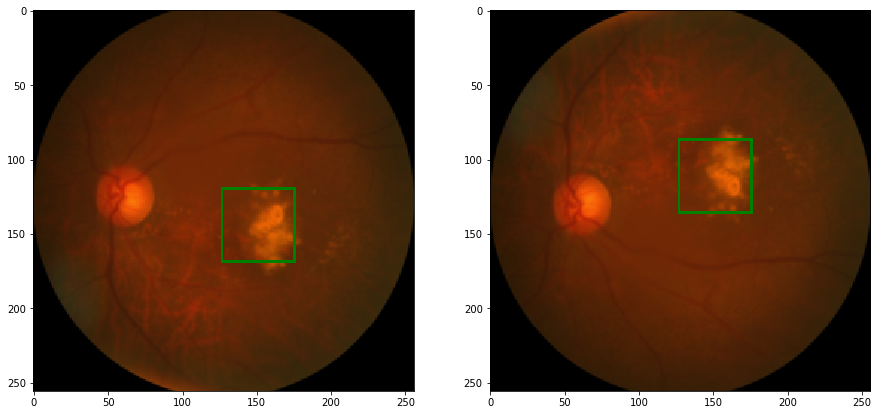

In [ ]:
# load image and label
img, label=load_img_label(labels_df,7)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# vertical flip
img_fv,label_fv=random_vflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fv,label_fv)

In [ ]:
import numpy as np
np.random.seed(1)

def random_shift(image,label,max_translate=(0.2,0.2)):
    w,h=image.size
    max_t_w, max_t_h=max_translate
    cx, cy=label

    # translate coeficinet, random [-1,1]
    trans_coef=np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)

    image=TF.affine(image,translate=(w_t, h_t),shear=0,angle=0,scale=1)
    label = cx+w_t, cy+h_t
        
    return image,label

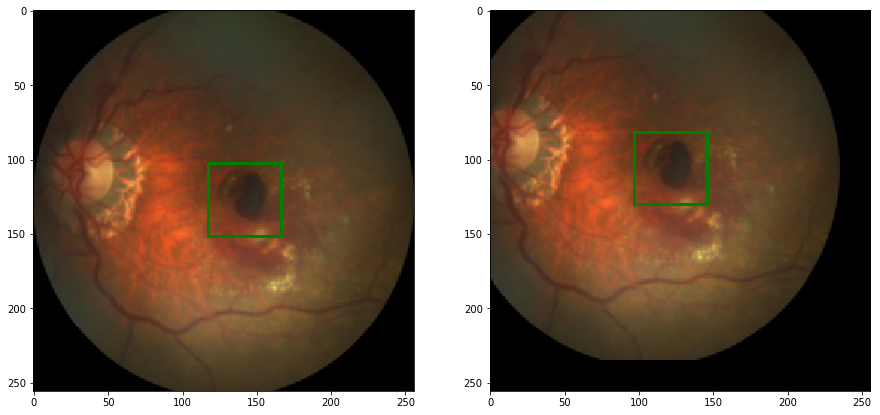

In [ ]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_t,label_t=random_shift(img_r,label_r,max_translate=(.5,.5))

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)

In [ ]:
def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])
    
    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])
        
    image=TF.to_tensor(image)
    return image, label

In [ ]:
import random
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)   

params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.2, 0.2),
}
img_t,label_t=transformer(img,label,params)

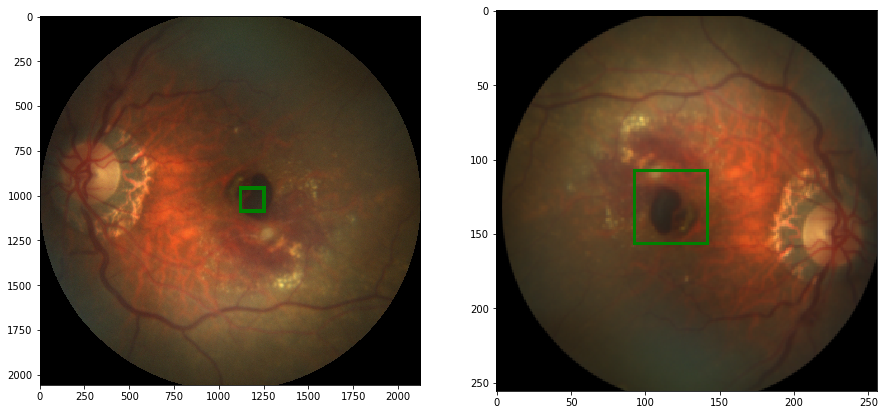

In [ ]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

## There is More

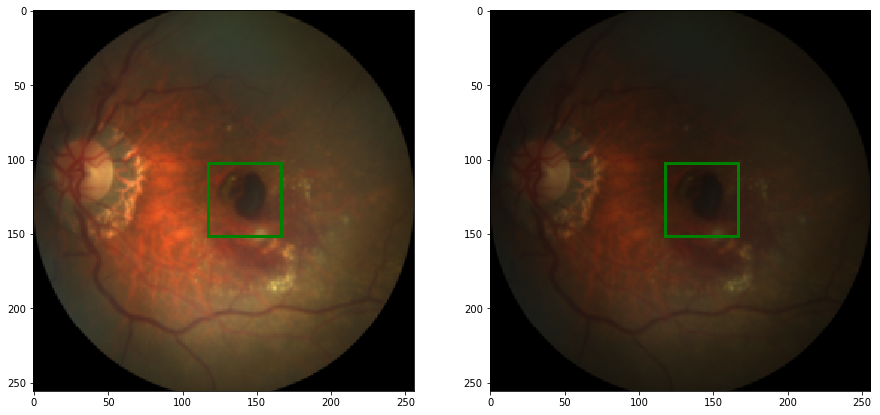

In [ ]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# adjust brightness
img_t=TF.adjust_brightness(img_r,brightness_factor=0.5)
label_t=label_r

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)

In [ ]:
# brightness
img_t=TF.adjust_contrast(img_r,contrast_factor=0.4)

# gamma correction
img_t=TF.adjust_gamma(img_r,gamma=1.4)

In [ ]:
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

In [ ]:
def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

In [ ]:
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)

In [ ]:
params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}
img_t,label_t=transformer(img,label,params)

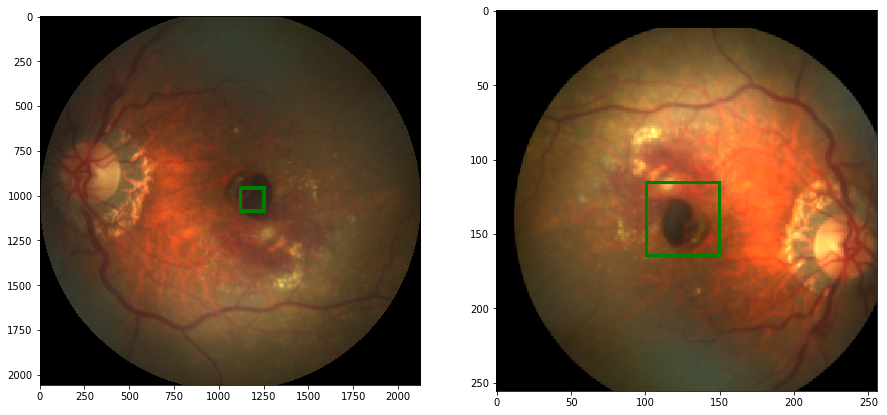

In [ ]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

In [ ]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

# Creating Custom Datasets

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):      
        pass    
      
    def __len__(self):
        # return size of dataset
        return len(self.labels)
      
    def __getitem__(self, idx):
        pass

In [ ]:
def __init__(self, path2data, transform, trans_params):      

    # full path of the labels file
    path2labels=os.path.join(path2data,"Training400_labels","Fovea_location.xlsx")

    # read and extract labels
    labels_df=pd.read_excel(path2labels,index_col="ID")
    self.labels = labels_df[["Fovea_X","Fovea_Y"]].values

    # extract ID and imgName columns
    self.imgName=labels_df["imgName"]
    self.ids=labels_df.index

    self.fullPath2img=[0]*len(self.ids)
    for id_ in self.ids:
        if self.imgName[id_][0]=="A":
            prefix="AMD"
        else:
            prefix="Non-AMD"
        self.fullPath2img[id_-1]=os.path.join(path2data,"Training400",prefix,self.imgName[id_])

    self.transform = transform
    self.trans_params=trans_params

In [ ]:
def __getitem__(self, idx):
    # load PIL image
    image = Image.open(self.fullPath2img[idx])  
    label= self.labels[idx]

    # transform to tensor
    image,label = self.transform(image,label,self.trans_params)

    return image, label

In [ ]:
AMD_dataset.__init__=__init__
AMD_dataset.__getitem__=__getitem__

In [ ]:
trans_params_train={
    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,    
}


In [ ]:
trans_params_val={
    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,    
}

In [ ]:
amd_ds1=AMD_dataset(path2data,transformer,trans_params_train)
amd_ds2=AMD_dataset(path2data,transformer,trans_params_val)

In [ ]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

320
----------
80


In [ ]:
from torch.utils.data import Subset

train_ds=Subset(amd_ds1,train_index)
print(len(train_ds))

val_ds=Subset(amd_ds2,val_index)
print(len(val_ds))

320
80


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

In [ ]:
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label=rescale_label(label,img.shape[1:])        
        x,y=label
        plt.plot(x,y,'b+',markersize=20) 

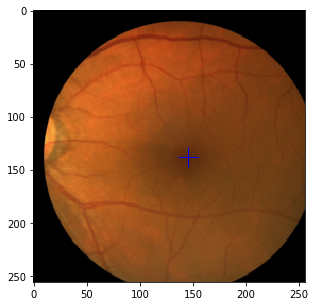

In [ ]:
plt.figure(figsize=(5,5))
for img,label in train_ds:
    show(img,label)
    break

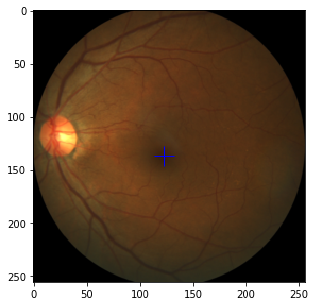

In [ ]:
plt.figure(figsize=(5,5))
for img,label in val_ds:
    show(img,label)
    break

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)  

In [ ]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.4825, 0.4530, 0.6596, 0.5515, 0.5801, 0.5192, 0.4439, 0.5710],
       dtype=torch.float64), tensor([0.5454, 0.4841, 0.6527, 0.5510, 0.5205, 0.5636, 0.4656, 0.7672],
       dtype=torch.float64)]


In [ ]:
import torch

# extract a batch from trainin data
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)

    # convert list to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 2]) torch.float32


In [ ]:
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)

    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 2]) torch.float32


# Creating the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [ ]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=2,padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,stride=1,padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [ ]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x    

In [ ]:
Net.__init__=__init__
Net.forward=forward


In [ ]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 2,
            }

model = Net(params_model)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device) 

In [ ]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


# Defining Loss, Optimizer and IOU Metric

In [ ]:
loss_func = nn.SmoothL1Loss(reduction="sum")    

In [ ]:
n,c=8,2
y = 0.5 * torch.ones(n, c, requires_grad=True)
print(y.shape)

target = torch.zeros(n, c, requires_grad=False)
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8, 2])
2.0
24.0


In [ ]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [ ]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    21: reducing learning rate of group 0 to 1.5000e-04.
Epoch    42: reducing learning rate of group 0 to 7.5000e-05.
Epoch    63: reducing learning rate of group 0 to 3.7500e-05.
Epoch    84: reducing learning rate of group 0 to 1.8750e-05.


In [ ]:
def cxcy2bbox(cxcy,w=50./256,h=50./256):
    # define two new tensors for w and h
    w_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*w
    h_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*h

    # extract cx and cy
    cx=cxcy[:,0].unsqueeze(1)
    cy=cxcy[:,1].unsqueeze(1)
    
    # concat cx,cy,w and h
    boxes=torch.cat((cx,cy, w_tensor, h_tensor), -1) # cx,cy,w,h
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax

In [ ]:
torch.manual_seed(0)

cxcy=torch.rand(1,2)
print("center:", cxcy*256)

bb=cxcy2bbox(cxcy)
print("bounding box", bb*256)

center: tensor([[127.0417, 196.6648]])
bounding box tensor([[102.0417, 171.6648, 152.0417, 221.6648]])


In [ ]:
import torchvision
def metrics_batch(output, target):
    output=cxcy2bbox(output)
    target=cxcy2bbox(target)
    
    iou=torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

In [ ]:
n,c=8,2
target = torch.rand(n, c, device=device)
target=cxcy2bbox(target)
metrics_batch(target,target)

8.0

In [ ]:
def loss_batch(loss_func, output, target, opt=None):   
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [ ]:
for xb,label_b in train_dl:
    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    label_b=label_b.to(device)
 
    l,m=loss_batch(loss_func,label_b,label_b)
    print(l,m)
    break

0.0 8.0


# Training and Evaluation of the Model

In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # convert to tensor
        yb=torch.stack(yb,1)
        yb=yb.type(torch.float32).to(device)
        
        # get model output
        output=model(xb.to(device))
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric
            

In [ ]:
import copy
def train_val(model, params):
    # extract parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        

In [ ]:
loss_func=nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 1,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smoothl1.pt",
}

# train and validate the model
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/0, current lr=0.0001
Copied best model weights!
train loss: 0.052517, accuracy: 16.17
val loss: 0.022405, accuracy: 27.38
----------


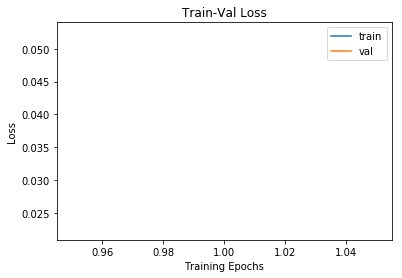

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

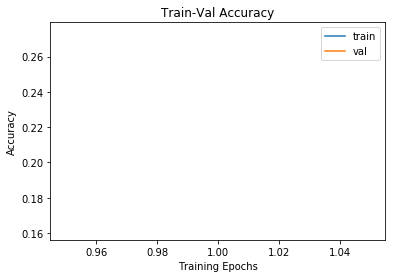

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()